In [ ]:
!pip install -qq seaborn
!pip install -qq gdown
!pip install -qq torchsummary
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms
import json
from torch.utils.data import Dataset, DataLoader
import os
from sklearn.model_selection import train_test_split
import torch.optim as optim
from PIL import Image
import random
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import math
from torchsummary import summary
import shutil
import pandas as pd
import csv


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
!gdown https://drive.google.com/uc?id=1TaMJ2GH0zGQIbupkU0r9cCntugcYNsYn
!unzip -qq ./podzielone_cutted.zip -d ./

Downloading...
From (uriginal): https://drive.google.com/uc?id=1TaMJ2GH0zGQIbupkU0r9cCntugcYNsYn
From (redirected): https://drive.google.com/uc?id=1TaMJ2GH0zGQIbupkU0r9cCntugcYNsYn&confirm=t&uuid=1d00d0a7-a457-4e9c-8152-a365fc5f6c0c
To: /kaggle/working/podzielone_cutted.zip
100%|█████████████████████████████████████████| 355M/355M [00:02<00:00, 155MB/s]


In [ ]:
def create_csv(directory, output_file):
    chess_table = []
    with open(output_file, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        cla = 0
        for class_folder in os.listdir(directory):
            class_path = os.path.join(directory, class_folder)
            if os.path.isdir(class_path):
                if class_folder.startswith("w_"):
                    class_name = class_folder[2:]
                elif class_folder.startswith("b_"):
                    class_name = class_folder[2:]
                else:
                    class_name = class_folder

                chess_table.append(class_name)
                for file in os.listdir(class_path):
                    if file.endswith('.png'):
                        image_path = os.path.join(class_path, file)
                        writer.writerow([image_path, cla])
                cla += 1
    return chess_table

directory = 'podzielone_cutted'
output_file = 'labels.csv'

class_ids = create_csv(directory, output_file)
print(class_ids)

['Q', 'r', 'q', 'b', 'empty', 'N', 'k', 'n', 'B', 'P', 'R', 'K', 'p']


In [ ]:
torch.cuda.empty_cache()

device = "cuda:0" if torch.cuda.is_available() else "cpu"


class ChessboardCNN(nn.Module):
    def __init__(self):
        super(ChessboardCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.dropout1 = nn.Dropout(0.25)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.dropout2 = nn.Dropout(0.25)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.dropout3 = nn.Dropout(0.25)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.dropout4 = nn.Dropout(0.25)
        self.conv5 = nn.Conv2d(256, 512, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.dropout5 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(512 * 1 * 1, 256)
        self.dropout6 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 13)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout1(x)
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout2(x)
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.dropout3(x)
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.dropout4(x)
        x = self.pool(F.relu(self.bn5(self.conv5(x))))
        x = self.dropout5(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout6(x)
        x = self.fc2(x)
        return x.view(-1, 13)

model = ChessboardCNN().to(device)
summary(model, input_size=(3, 50, 50))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 50, 50]             896
       BatchNorm2d-2           [-1, 32, 50, 50]              64
         MaxPool2d-3           [-1, 32, 25, 25]               0
           Dropout-4           [-1, 32, 25, 25]               0
            Conv2d-5           [-1, 64, 25, 25]          18,496
       BatchNorm2d-6           [-1, 64, 25, 25]             128
         MaxPool2d-7           [-1, 64, 12, 12]               0
           Dropout-8           [-1, 64, 12, 12]               0
            Conv2d-9          [-1, 128, 12, 12]          73,856
      BatchNorm2d-10          [-1, 128, 12, 12]             256
        MaxPool2d-11            [-1, 128, 6, 6]               0
          Dropout-12            [-1, 128, 6, 6]               0
           Conv2d-13            [-1, 256, 6, 6]         295,168
      BatchNorm2d-14            [-1, 25

In [ ]:
class ChessDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = self.annotations.iloc[index, 0]
        image = Image.open(img_path)
        y_label = self.annotations.iloc[index, 1]

        if self.transform:
            image = self.transform(image)

        sample = {'image': image, 'y_label': y_label, 'image_path': img_path}

        return sample

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Subset, DataLoader
from torchvision import transforms
mean = [0.6024, 0.4147, 0.2778]
std = [0.1996, 0.1624, 0.1518]
file_path = 'labels.csv'
labels_df = pd.read_csv(file_path)

image_paths = labels_df.iloc[:, 0].values
labels = labels_df.iloc[:, 1].values

data_transform = transforms.Compose([
    transforms.Resize((50, 50)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
csv_file = 'labels.csv'
root_dir = 'podzielone_cutted'
full_dataset = ChessDataset(csv_file, root_dir, data_transform)

total_size = len(labels)
train_size = int(0.74 * total_size)
val_size = int(0.13 * total_size)
test_size = total_size - train_size - val_size

train_idx, test_val_idx = train_test_split(
    np.arange(len(labels)), stratify=labels, test_size=(val_size + test_size), random_state=42
)
test_idx, val_idx = train_test_split(
    test_val_idx, stratify=labels[test_val_idx], test_size=test_size, random_state=42
)

train_dataset = Subset(full_dataset, train_idx)
test_dataset = Subset(full_dataset, test_idx)
val_dataset = Subset(full_dataset, val_idx)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

len(train_loader), len(test_loader), len(val_loader)

(1884, 331, 331)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/1884 [00:00<?, ?it/s]

Epoka [1], Strata Treningowa: 2.0098, Strata Walidacyjna: 2.8201, Dokładność Treningowa: 25.05%, Dokładność Walidacyjna: 17.16%


  0%|          | 0/1884 [00:00<?, ?it/s]

Epoka [2], Strata Treningowa: 1.5523, Strata Walidacyjna: 1.6397, Dokładność Treningowa: 40.66%, Dokładność Walidacyjna: 40.24%


  0%|          | 0/1884 [00:00<?, ?it/s]

Epoka [3], Strata Treningowa: 1.2935, Strata Walidacyjna: 1.0617, Dokładność Treningowa: 51.30%, Dokładność Walidacyjna: 59.42%


  0%|          | 0/1884 [00:00<?, ?it/s]

Epoka [4], Strata Treningowa: 1.0827, Strata Walidacyjna: 0.8030, Dokładność Treningowa: 59.69%, Dokładność Walidacyjna: 70.17%


  0%|          | 0/1884 [00:00<?, ?it/s]

Epoka [5], Strata Treningowa: 0.9334, Strata Walidacyjna: 0.6591, Dokładność Treningowa: 66.25%, Dokładność Walidacyjna: 77.66%


  0%|          | 0/1884 [00:00<?, ?it/s]

Epoka [6], Strata Treningowa: 0.8094, Strata Walidacyjna: 0.5547, Dokładność Treningowa: 71.58%, Dokładność Walidacyjna: 81.53%


  0%|          | 0/1884 [00:00<?, ?it/s]

Epoka [7], Strata Treningowa: 0.7013, Strata Walidacyjna: 0.4744, Dokładność Treningowa: 75.98%, Dokładność Walidacyjna: 84.08%


  0%|          | 0/1884 [00:00<?, ?it/s]

Epoka [8], Strata Treningowa: 0.6298, Strata Walidacyjna: 0.4239, Dokładność Treningowa: 78.20%, Dokładność Walidacyjna: 85.27%


  0%|          | 0/1884 [00:00<?, ?it/s]

Epoka [9], Strata Treningowa: 0.5680, Strata Walidacyjna: 0.3593, Dokładność Treningowa: 80.55%, Dokładność Walidacyjna: 87.84%


  0%|          | 0/1884 [00:00<?, ?it/s]

Epoka [10], Strata Treningowa: 0.5153, Strata Walidacyjna: 0.3596, Dokładność Treningowa: 82.53%, Dokładność Walidacyjna: 87.99%


  0%|          | 0/1884 [00:00<?, ?it/s]

Epoka [11], Strata Treningowa: 0.4723, Strata Walidacyjna: 0.3315, Dokładność Treningowa: 83.98%, Dokładność Walidacyjna: 89.12%


  0%|          | 0/1884 [00:00<?, ?it/s]

Epoka [12], Strata Treningowa: 0.4372, Strata Walidacyjna: 0.3154, Dokładność Treningowa: 85.28%, Dokładność Walidacyjna: 89.41%


  0%|          | 0/1884 [00:00<?, ?it/s]

Epoka [13], Strata Treningowa: 0.4035, Strata Walidacyjna: 0.2701, Dokładność Treningowa: 86.29%, Dokładność Walidacyjna: 91.48%


  0%|          | 0/1884 [00:00<?, ?it/s]

Epoka [14], Strata Treningowa: 0.3783, Strata Walidacyjna: 0.2598, Dokładność Treningowa: 87.39%, Dokładność Walidacyjna: 91.65%


  0%|          | 0/1884 [00:00<?, ?it/s]

Epoka [15], Strata Treningowa: 0.3540, Strata Walidacyjna: 0.2502, Dokładność Treningowa: 87.93%, Dokładność Walidacyjna: 92.20%


  0%|          | 0/1884 [00:00<?, ?it/s]

Epoka [16], Strata Treningowa: 0.3315, Strata Walidacyjna: 0.2404, Dokładność Treningowa: 88.85%, Dokładność Walidacyjna: 92.30%


  0%|          | 0/1884 [00:00<?, ?it/s]

Epoka [17], Strata Treningowa: 0.3133, Strata Walidacyjna: 0.2297, Dokładność Treningowa: 89.54%, Dokładność Walidacyjna: 92.84%


  0%|          | 0/1884 [00:00<?, ?it/s]

Epoka [18], Strata Treningowa: 0.2906, Strata Walidacyjna: 0.2118, Dokładność Treningowa: 90.13%, Dokładność Walidacyjna: 93.54%


  0%|          | 0/1884 [00:00<?, ?it/s]

Epoka [19], Strata Treningowa: 0.2749, Strata Walidacyjna: 0.2095, Dokładność Treningowa: 90.83%, Dokładność Walidacyjna: 93.56%


  0%|          | 0/1884 [00:00<?, ?it/s]

Epoka [20], Strata Treningowa: 0.2587, Strata Walidacyjna: 0.1930, Dokładność Treningowa: 91.16%, Dokładność Walidacyjna: 93.94%


  0%|          | 0/1884 [00:00<?, ?it/s]

Epoka [21], Strata Treningowa: 0.2426, Strata Walidacyjna: 0.1899, Dokładność Treningowa: 91.80%, Dokładność Walidacyjna: 94.05%


  0%|          | 0/1884 [00:00<?, ?it/s]

Epoka [22], Strata Treningowa: 0.2323, Strata Walidacyjna: 0.1779, Dokładność Treningowa: 92.10%, Dokładność Walidacyjna: 94.56%


  0%|          | 0/1884 [00:00<?, ?it/s]

Epoka [23], Strata Treningowa: 0.2238, Strata Walidacyjna: 0.1735, Dokładność Treningowa: 92.31%, Dokładność Walidacyjna: 94.68%


  0%|          | 0/1884 [00:00<?, ?it/s]

Epoka [24], Strata Treningowa: 0.2099, Strata Walidacyjna: 0.1952, Dokładność Treningowa: 92.98%, Dokładność Walidacyjna: 93.90%


  0%|          | 0/1884 [00:00<?, ?it/s]

Epoka [25], Strata Treningowa: 0.2047, Strata Walidacyjna: 0.1716, Dokładność Treningowa: 93.18%, Dokładność Walidacyjna: 94.88%


  0%|          | 0/1884 [00:00<?, ?it/s]

Epoka [26], Strata Treningowa: 0.1941, Strata Walidacyjna: 0.1682, Dokładność Treningowa: 93.49%, Dokładność Walidacyjna: 94.85%


  0%|          | 0/1884 [00:00<?, ?it/s]

Epoka [27], Strata Treningowa: 0.1825, Strata Walidacyjna: 0.1595, Dokładność Treningowa: 93.69%, Dokładność Walidacyjna: 95.09%


  0%|          | 0/1884 [00:00<?, ?it/s]

Epoka [28], Strata Treningowa: 0.1779, Strata Walidacyjna: 0.1578, Dokładność Treningowa: 94.01%, Dokładność Walidacyjna: 94.92%


  0%|          | 0/1884 [00:00<?, ?it/s]

Epoka [29], Strata Treningowa: 0.1690, Strata Walidacyjna: 0.1588, Dokładność Treningowa: 94.21%, Dokładność Walidacyjna: 95.07%


  0%|          | 0/1884 [00:00<?, ?it/s]

Epoka [30], Strata Treningowa: 0.1629, Strata Walidacyjna: 0.1363, Dokładność Treningowa: 94.59%, Dokładność Walidacyjna: 95.88%


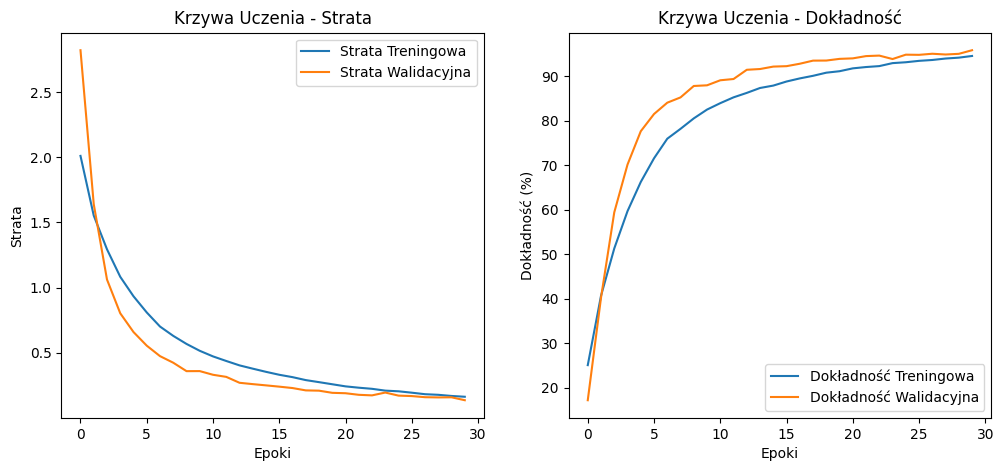

In [ ]:
num_epochs = 30
lr = 0.00005
optimizer = optim.Adam(model.parameters(), lr)
criterion = nn.CrossEntropyLoss()

training_losses = []
validation_losses = []
training_accuracies = []
validation_accuracies = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0

    for batch_idx, batch in enumerate(tqdm(train_loader, leave=False)):
        images, labels = batch['image'].to(device), batch['y_label'].to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        optimizer.zero_grad()
        total_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    average_train_loss = total_train_loss / len(train_loader)
    training_losses.append(average_train_loss)
    train_accuracy = 100 * correct_train / total_train
    training_accuracies.append(train_accuracy)

    model.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for batch in val_loader:
            images, labels = batch['image'].to(device), batch['y_label'].to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    average_val_loss = total_val_loss / len(val_loader)
    validation_losses.append(average_val_loss)
    val_accuracy = 100 * correct_val / total_val
    validation_accuracies.append(val_accuracy)


    print(f'Epoka [{epoch+1}], Strata Treningowa: {average_train_loss:.4f}, Strata Walidacyjna: {average_val_loss:.4f}, Dokładność Treningowa: {train_accuracy:.2f}%, Dokładność Walidacyjna: {val_accuracy:.2f}%')

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(training_losses, label='Strata Treningowa')
plt.plot(validation_losses, label='Strata Walidacyjna')
plt.title('Krzywa Uczenia - Strata')
plt.xlabel('Epoki')
plt.ylabel('Strata')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(training_accuracies, label='Dokładność Treningowa')
plt.plot(validation_accuracies, label='Dokładność Walidacyjna')
plt.title('Krzywa Uczenia - Dokładność')
plt.xlabel('Epoki')
plt.ylabel('Dokładność (%)')
plt.legend()

plt.show()


Dokładność na zbiorze testowym: 95.20%


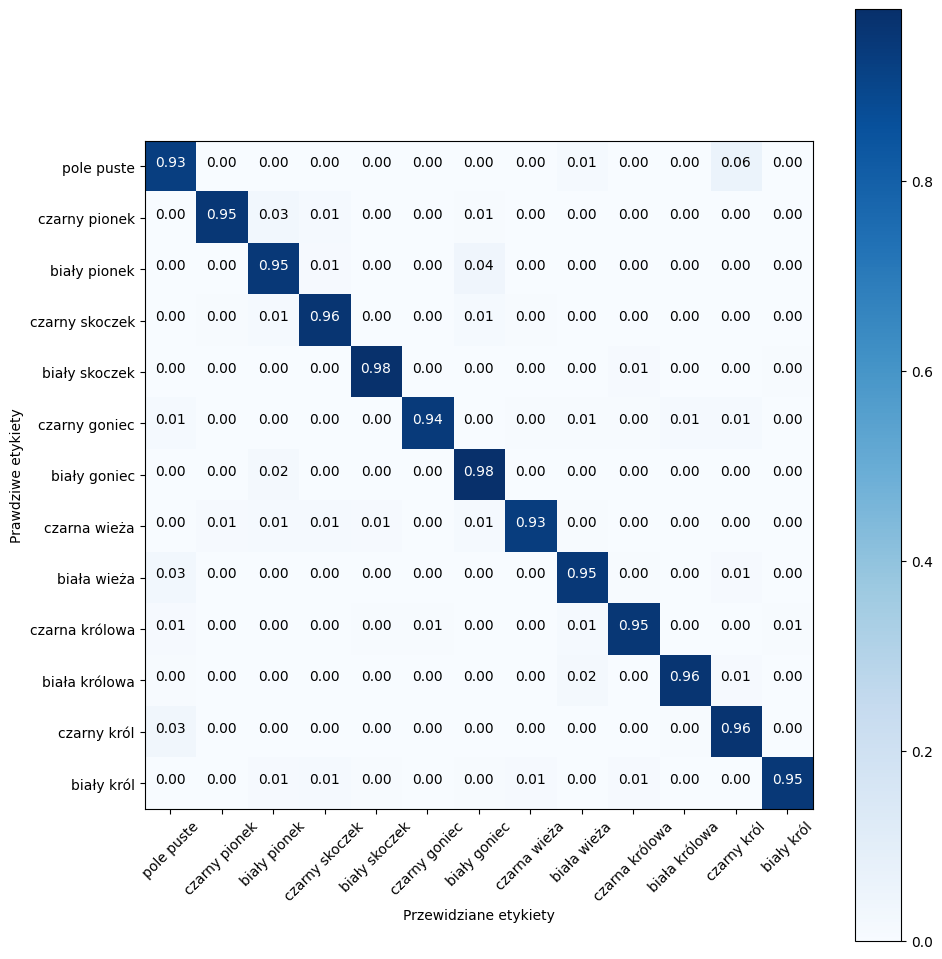

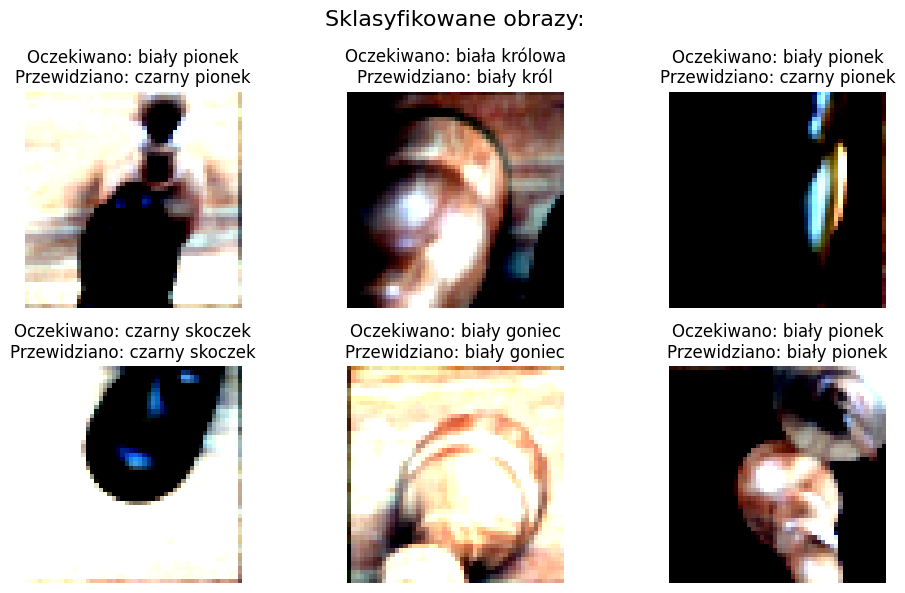

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

class_names = {
    'empty': 'pole puste',
    'p': 'czarny pionek', 'P': 'biały pionek',
    'n': 'czarny skoczek', 'N': 'biały skoczek',
    'b': 'czarny goniec', 'B': 'biały goniec',
    'r': 'czarna wieża', 'R': 'biała wieża',
    'q': 'czarny hetman', 'Q': 'biały hetman',
    'k': 'czarny król', 'K': 'biały król'
}

def plot_confusion_matrix(cm, classes):
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10, 10))
    plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    for i in range(cm_normalized.shape[0]):
        for j in range(cm_normalized.shape[1]):
            plt.text(j, i, "{:.2f}".format(cm_normalized[i, j]),
                     horizontalalignment="center",
                     color="white" if cm_normalized[i, j] > 0.5 else "black")

    plt.xlabel('Przewidziane etykiety')
    plt.ylabel('Prawdziwe etykiety')
    plt.tight_layout()
    plt.show()

criterion = nn.CrossEntropyLoss()
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    misclassified_images = []
    misclassified_labels = []
    misclassified_predictions = []
    correctly_classified_images = []
    correctly_classified_labels = []
    correctly_classified_predictions = []
    predicted_table = []
    true_table = []

    for batch in test_loader:
        images, labels = batch['image'].to(device), batch['y_label'].to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        for i in range(len(predicted)):
            predicted_table.append(predicted[i].item())
            true_table.append(labels[i].item())

            if predicted[i] != labels[i]:
                if len(misclassified_images) < 3:
                    misclassified_images.append(images[i])
                    misclassified_labels.append(labels[i])
                    misclassified_predictions.append(predicted[i])
            else:
                if len(correctly_classified_images) < 3:
                    correctly_classified_images.append(images[i])
                    correctly_classified_labels.append(labels[i])
                    correctly_classified_predictions.append(predicted[i])

    accuracy = 100 * correct / total
    print(f'Dokładność na zbiorze testowym: {accuracy:.2f}%')

cm = confusion_matrix(true_table, predicted_table)
plot_confusion_matrix(cm, [class_names.get(k, k) for k in class_names.keys()])

fig, axs = plt.subplots(2, 3, figsize=(10, 6))
axs = axs.flatten()

for i in range(3):
    image = misclassified_images[i].cpu().numpy()
    label = misclassified_labels[i].cpu().numpy()
    prediction = misclassified_predictions[i].cpu().numpy()

    normalized_image = np.transpose(image, (1, 2, 0))
    normalized_image = np.clip(normalized_image, 0, 1)
    axs[i].imshow(normalized_image)
    axs[i].set_title(f"Oczekiwano: {class_names[class_ids[label.item()]]}\nPrzewidziano: {class_names[class_ids[prediction.item()]]}")
    axs[i].axis('off')

for i in range(3, 6):
    image = correctly_classified_images[i - 3].cpu().numpy()
    label = correctly_classified_labels[i - 3].cpu().numpy()
    prediction = correctly_classified_predictions[i - 3].cpu().numpy()

    normalized_image = np.transpose(image, (1, 2, 0))
    normalized_image = np.clip(normalized_image, 0, 1)
    axs[i].imshow(normalized_image)
    axs[i].set_title(f"Oczekiwano: {class_names[class_ids[label.item()]]}\nPrzewidziano: {class_names[class_ids[prediction.item()]]}")
    axs[i].axis('off')

fig.suptitle("Sklasyfikowane obrazy:", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
torch.save(model, 'model.pth')